In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing Libraries for our model**

In [10]:
import pandas as pd
import pylab as pl
import numpy as np
import string
import matplotlib as plot
from sklearn.manifold import TSNE
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [11]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

In [12]:
print(tf.__version__)

2.15.0


In [13]:
df = pd.read_csv(r"/content/drive/MyDrive/ML_FOLDER/ai-project/stock price prediction/csv/EURUSD_o_Daily_2023-02-0_2024-04-10.csv", sep='\t')

df.shape

(315, 8)

In [14]:
df.columns = ['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL', 'VOL', 'SPREAD']

In [15]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     315 non-null    object 
 1   OPEN     315 non-null    float64
 2   HIGH     315 non-null    float64
 3   LOW      315 non-null    float64
 4   CLOSE    315 non-null    float64
 5   TICKVOL  315 non-null    int64  
 6   VOL      315 non-null    int64  
 7   SPREAD   315 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 19.8+ KB


In [16]:
df.head()

,DATE,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD
0,2023.02.01,1.08610,1.10010,1.08522,1.09890,97681,0,0
1,2023.02.02,1.09893,1.10330,1.08854,1.09097,117680,0,0
2,2023.02.03,1.09097,1.09402,1.07924,1.07943,106371,0,0
3,2023.02.06,1.07809,1.07990,1.07096,1.07252,92317,0,0
4,2023.02.07,1.07263,1.07666,1.06692,1.07238,112750,0,0


In [17]:
date_time = pd.to_datetime(df.pop('DATE'), format='%Y.%m.%d')
print(df.dtypes)

OPEN       float64
HIGH       float64
LOW        float64
CLOSE      float64
TICKVOL      int64
VOL          int64
SPREAD       int64
dtype: object


# in conclusion VOL and SPREAD are worthless and i will drop them

In [18]:
df = df.drop('VOL', axis=1)
df = df.drop('SPREAD', axis=1)
df.shape


(315, 5)

In [19]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
OPEN,315.0,1.082466,0.015067,1.04667,1.071855,1.08431,1.093455,1.12335
HIGH,315.0,1.086091,0.015051,1.04936,1.075260,1.08765,1.096540,1.12758
LOW,315.0,1.079032,0.014953,1.04483,1.068920,1.08071,1.089695,1.12090
CLOSE,315.0,1.082437,0.015048,1.04663,1.072030,1.08436,1.093325,1.12335
TICKVOL,315.0,70586.565079,21862.528062,164.00000,58522.000000,69973.00000,80589.500000,178097.00000


In [20]:
import datetime
timestamp_s = date_time.map(datetime.datetime.timestamp)

# split data

In [21]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print(f'There are {num_features} features')

There are 5 features


Normlize Data

In [22]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

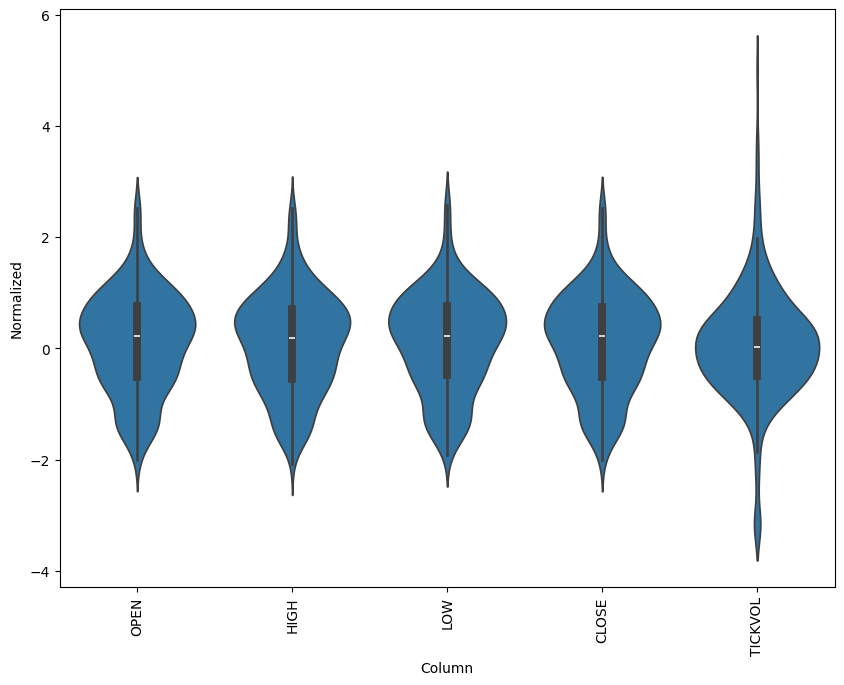

In [23]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [24]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='Appliances', max_subplots=3):
        inputs, labels = self.example

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=3):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=MAX_EPOCHS,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

In [25]:
single_step_window = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1
)

wide_window = WindowGenerator(
    input_width=24,
    label_width=24,
    shift=1
)

CONV_WIDTH = 3

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1
)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 5)
Labels shape (batch, time, features): (32, 24, 5)


# LSTM

In [30]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)
val_performance = {}
performance = {}

val_performance['dense'] = dense.evaluate(single_step_window.val)
performance['dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
7/7 [==============================] - 2s 53ms/step - loss: 0.9396 - mean_absolute_error: 0.7670 - val_loss: 0.5583 - val_mean_absolute_error: 0.5591
Epoch 2/50
7/7 [==============================] - 0s 21ms/step - loss: 0.7272 - mean_absolute_error: 0.6610 - val_loss: 0.4602 - val_mean_absolute_error: 0.4997
Epoch 3/50
7/7 [==============================] - 0s 22ms/step - loss: 0.5564 - mean_absolute_error: 0.5623 - val_loss: 0.3939 - val_mean_absolute_error: 0.4557
Epoch 4/50
7/7 [==============================] - 0s 16ms/step - loss: 0.4363 - mean_absolute_error: 0.4765 - val_loss: 0.3306 - val_mean_absolute_error: 0.4089
Epoch 5/50
7/7 [==============================] - 0s 20ms/step - loss: 0.3443 - mean_absolute_error: 0.3977 - val_loss: 0.2664 - val_mean_absolute_error: 0.3524
Epoch 6/50
7/7 [==============================] - 0s 17ms/step - loss: 0.2729 - mean_absolute_error: 0.3361 - val_loss: 0.2156 - val_mean_absolute_error: 0.3023
Epoch 7/50
7/7 [==================

# CNN + LSTM

In [31]:
cnn_lstm_model = Sequential([
    Conv1D(filters=64,
           kernel_size=(CONV_WIDTH,),
           activation='relu'),
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
7/7 [==============================] - 7s 197ms/step - loss: 0.9804 - mean_absolute_error: 0.8151 - val_loss: 0.4851 - val_mean_absolute_error: 0.5346
Epoch 2/50
7/7 [==============================] - 0s 12ms/step - loss: 0.9012 - mean_absolute_error: 0.7812 - val_loss: 0.4425 - val_mean_absolute_error: 0.5060
Epoch 3/50
7/7 [==============================] - 0s 19ms/step - loss: 0.7575 - mean_absolute_error: 0.7099 - val_loss: 0.3537 - val_mean_absolute_error: 0.4409
Epoch 4/50
7/7 [==============================] - 0s 12ms/step - loss: 0.5772 - mean_absolute_error: 0.5736 - val_loss: 0.2452 - val_mean_absolute_error: 0.3364
Epoch 5/50
7/7 [==============================] - 0s 12ms/step - loss: 0.5288 - mean_absolute_error: 0.4584 - val_loss: 0.2277 - val_mean_absolute_error: 0.3085
Epoch 6/50
7/7 [==============================] - 0s 14ms/step - loss: 0.5231 - mean_absolute_error: 0.4533 - val_loss: 0.2286 - val_mean_absolute_error: 0.3169
Epoch 7/50
7/7 [=================

Resnet

In [33]:
class ResidualWrapper(Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        return inputs + delta

In [34]:
res_lstm = ResidualWrapper(
    Sequential([
        LSTM(32, return_sequences=True),
        Dense(
            num_features,
            kernel_initializer=tf.initializers.zeros    # Initialize predictions to 0
        )
    ])
)

history = compile_and_fit(res_lstm, wide_window)

val_performance['res_lstm'] = res_lstm.evaluate(wide_window.val)
performance['res_lstm'] = res_lstm.evaluate(wide_window.test, verbose=0)

Epoch 1/50
7/7 [==============================] - 4s 82ms/step - loss: 0.3202 - mean_absolute_error: 0.2944 - val_loss: 0.2091 - val_mean_absolute_error: 0.2685
Epoch 2/50
7/7 [==============================] - 0s 11ms/step - loss: 0.3182 - mean_absolute_error: 0.2930 - val_loss: 0.2080 - val_mean_absolute_error: 0.2676
Epoch 3/50
7/7 [==============================] - 0s 13ms/step - loss: 0.3158 - mean_absolute_error: 0.2923 - val_loss: 0.2071 - val_mean_absolute_error: 0.2671
Epoch 4/50
7/7 [==============================] - 0s 11ms/step - loss: 0.3129 - mean_absolute_error: 0.2915 - val_loss: 0.2064 - val_mean_absolute_error: 0.2666
Epoch 5/50
7/7 [==============================] - 0s 11ms/step - loss: 0.3097 - mean_absolute_error: 0.2907 - val_loss: 0.2055 - val_mean_absolute_error: 0.2662
Epoch 6/50
7/7 [==============================] - 0s 11ms/step - loss: 0.3056 - mean_absolute_error: 0.2898 - val_loss: 0.2041 - val_mean_absolute_error: 0.2654
Epoch 7/50
7/7 [==================

In [35]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

dense       : 0.2843
CNN+LSTM    : 0.3485
res_lstm    : 0.2820
